In [1]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [6]:
for category in os.listdir('train'):
    if "DS_Store" in category:
        continue
    print(f"{category}: {len(os.listdir(os.path.join('train', category)))} images")


0: 2176 images
4: 2258 images
2: 2404 images
3: 2499 images
5: 2363 images
1: 2258 images


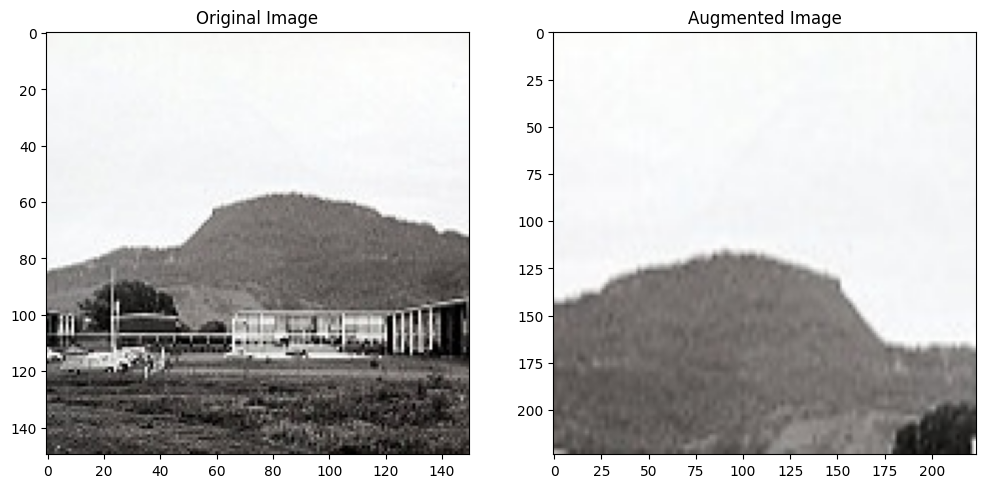

In [11]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image

# 加载一个图像
train_data = datasets.ImageFolder(root='train')
img_path, label = train_data.samples[0]
image = Image.open(img_path)

# 定义数据增强
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
])

# 对图像进行增强
augmented_image = data_transform(image)

# 展示原图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  
plt.title('Original Image')
plt.imshow(image)

# 展示增强后的图像
plt.subplot(1, 2, 2)
plt.title('Augmented Image')
plt.imshow(augmented_image)

#展示图像
plt.show()

In [ ]:
import torch
from torch.utils.data import random_split, ConcatDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 数据预处理
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 数据增强转换
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集并划分训练集和验证集
# 加载数据集
dataset = datasets.ImageFolder(root='train', transform=transform)
aug_dataset = datasets.ImageFolder(root='train', transform=aug_transform)

# 将原始训练集与增强后的训练集进行合并
dataset = ConcatDataset([dataset, aug_dataset])

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 打印训练集和验证集的大小
print('Training set size:', len(train_dataset))
print('Validation set size:', len(val_dataset))


# 创建数据加载器
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=128)

# 加载预训练的resnet50模型并移至GPU
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 6)

# 如果有多个GPU，则将模型复制到几个GPU上
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

# 将模型移动到GPU
model.to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练和验证
best_acc = 0.0
for epoch in range(5):
    print("start epoch: ", epoch, ".")
    # 训练阶段
    running_loss = 0.0
    correct, total = 0, 0
    
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), ncols=80)
    for i, data in pbar:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(trainloader)))
    print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

    # 验证阶段
    correct, total = 0, 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # 计算验证集准确率
    val_acc = 100 * correct / total
    # 保存最好的模型
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), './best_model.pth')

    print('Accuracy of the network on the validation images: %d %%' % (100 * correct / total))

print('Finished Training')



Training set size: 25138
Validation set size: 2794


/home/research/anaconda3/envs/liuyang09/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/research/anaconda3/envs/liuyang09/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Let's use 4 GPUs!
start epoch:  0 .


100%|█████████████████████████████████████████| 197/197 [03:07<00:00,  1.05it/s]


Epoch 0 - Training loss: 0.4323051166413399
Accuracy of the network on the train images: 84 %
Accuracy of the network on the validation images: 84 %
start epoch:  1 .


100%|█████████████████████████████████████████| 197/197 [03:02<00:00,  1.08it/s]


Epoch 1 - Training loss: 0.31096714961952365
Accuracy of the network on the train images: 89 %
Accuracy of the network on the validation images: 88 %
start epoch:  2 .


100%|█████████████████████████████████████████| 197/197 [03:08<00:00,  1.05it/s]


Epoch 2 - Training loss: 0.25371121066778446
Accuracy of the network on the train images: 91 %
Accuracy of the network on the validation images: 89 %
start epoch:  3 .


100%|█████████████████████████████████████████| 197/197 [02:58<00:00,  1.11it/s]


Epoch 3 - Training loss: 0.22280253360265403
Accuracy of the network on the train images: 92 %
Accuracy of the network on the validation images: 91 %
start epoch:  4 .


 81%|█████████████████████████████████        | 159/197 [02:27<00:37,  1.02it/s]

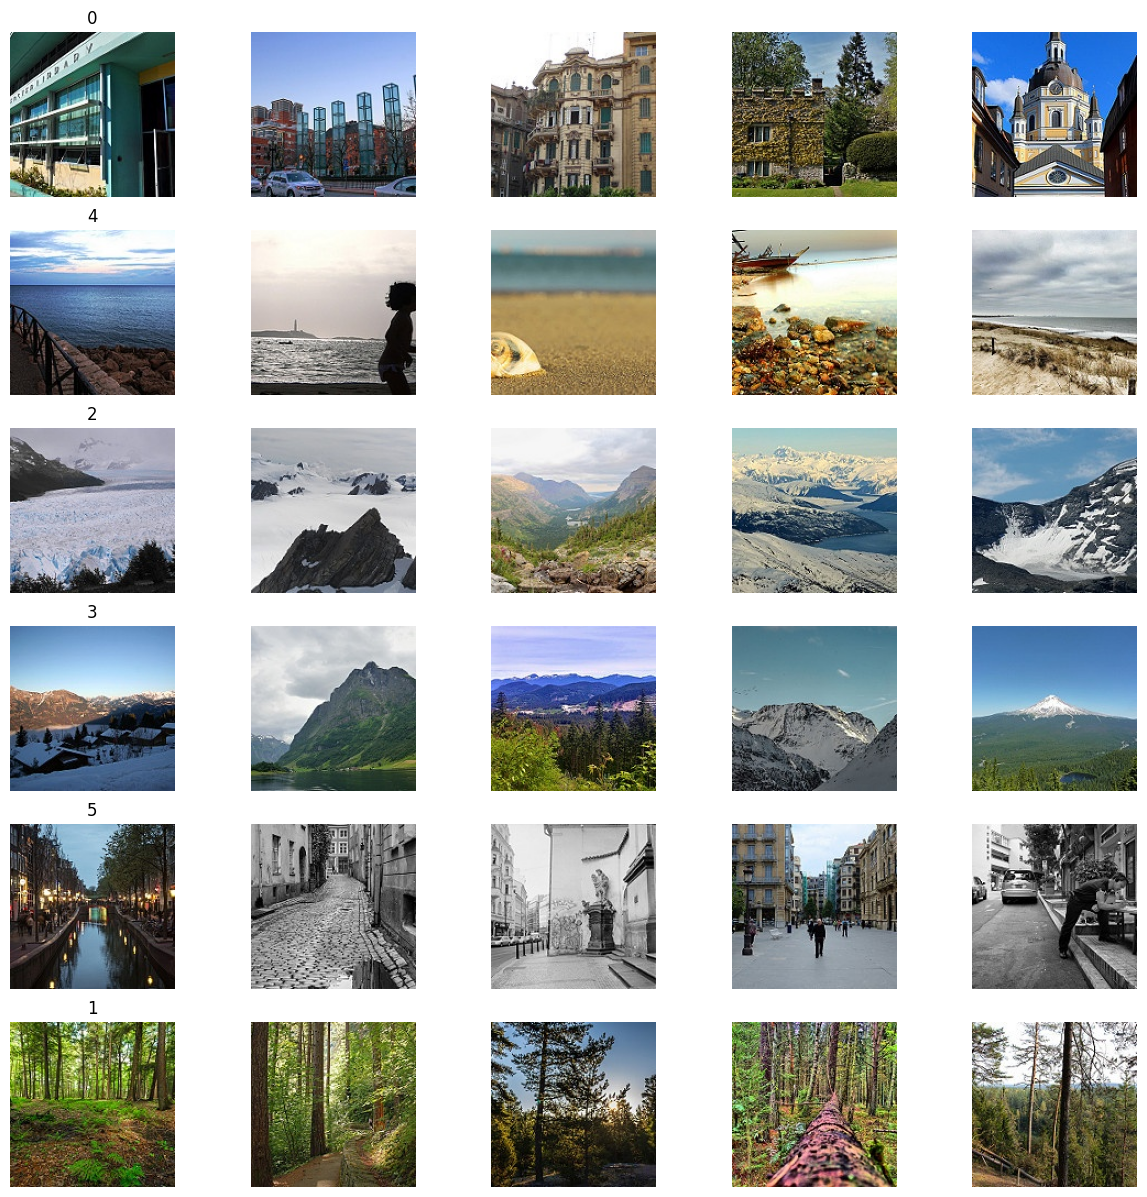

In [31]:
import matplotlib.pyplot as plt
import os
from PIL import Image

train_dir = "train"
classes = os.listdir(train_dir)

fig, axs = plt.subplots(len(classes), 5, figsize=(15, 15)) # 设定画布大小

for i, cls in enumerate(classes):
    if "DS_Store" in cls:
        continue
    cls_dir = os.path.join(train_dir, cls)
    images = os.listdir(cls_dir)[:5] # 获取每个类别下的前5张图片
    for j, img in enumerate(images):
        img_path = os.path.join(cls_dir, img)
        image = Image.open(img_path)
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(cls) # 设置图像标题为类别名


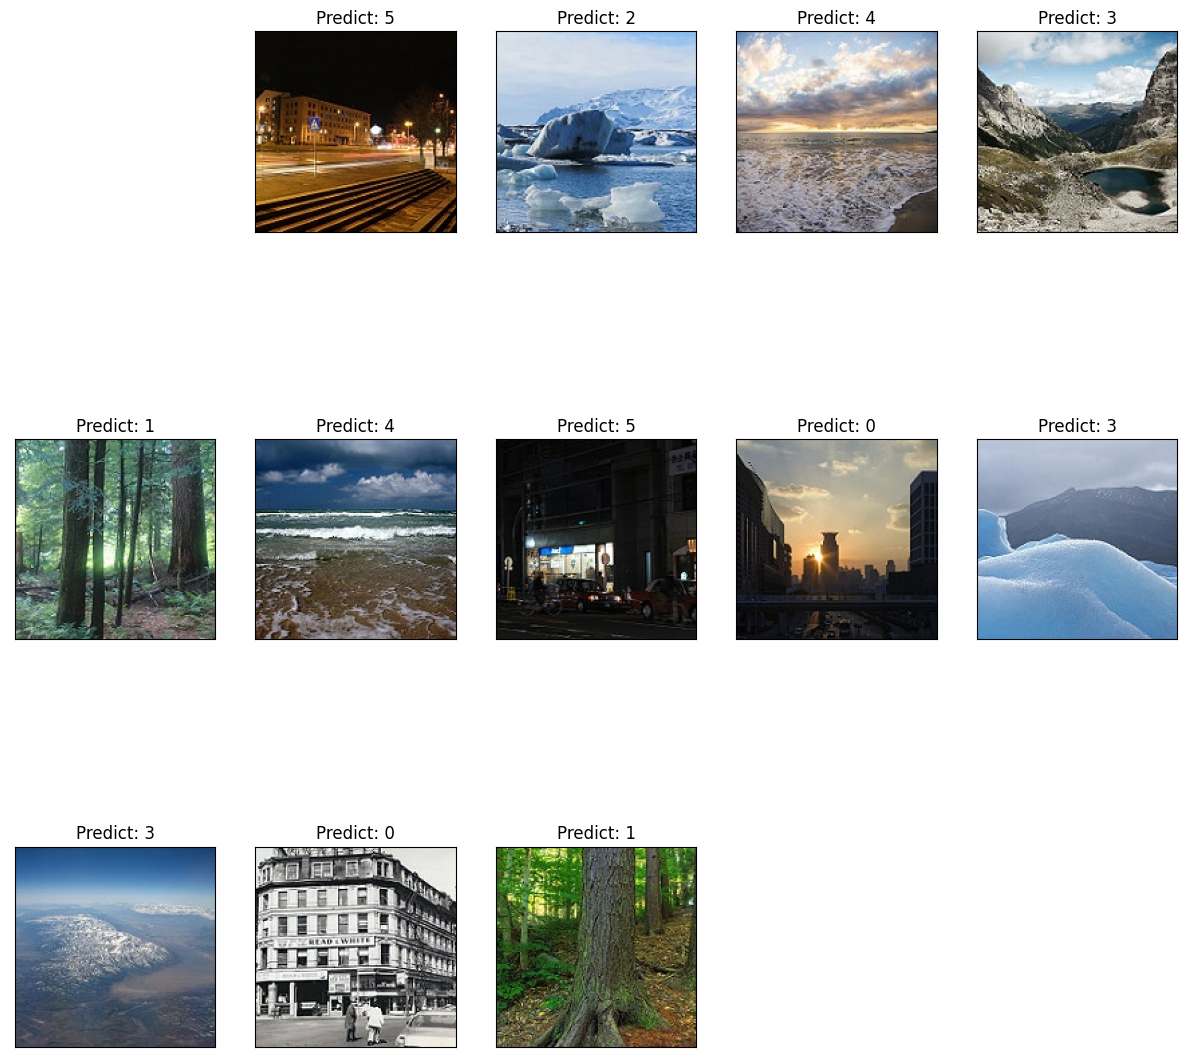

In [34]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# 指定测试图片目录
test_dir = "./sample_test"

# 获取测试图片列表
test_images = os.listdir(test_dir)

# 开始模型推理并显示图片
model.eval() # 设置模型为评估模式
fig = plt.figure(figsize=(15, 15))

for i, img in enumerate(test_images):
    if not img.endswith(".jpg"):
        continue
    img_path = os.path.join(test_dir, img)
    image = Image.open(img_path)
    input = transform(image).unsqueeze(0).to(device) # 对图片进行预处理并移至GPU
    output = model(input)
    _, predicted = torch.max(output, 1)
    predicted_class = predicted.item()
    
    # 显示图片和模型推理结果
    ax = fig.add_subplot(len(test_images) // 5 + 1, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(image)
    ax.set_title('Predict: {}'.format(predicted_class))

plt.show()
